Columns Description
- Source Port, Client Source Port 
- Destination Port, Client Destination Port 
- NAT Source Port, Network Address Translation Source Port 
- NAT Destination Port, Network Address Translation Destination Port 
- Elapsed Time (sec), Elapsed Time for flow 
- Bytes, Total Bytes 
- Bytes Sent, Bytes Sent 
- Bytes Received, Bytes Received 
- Packets, Total Packets 
- pkts_sent, Packets Sent 
- pkts_received, Packets Received
- Action, Class (allow, deny, drop, reset-both)

Target Values
- Allow, Allows the internet traffic. 
- Deny, Blocks traffic and enforces the default Deny Action defined for the application that is being denied. 
- Drop, Silently drops the traffic; for an application, it overrides the default deny action. A TCP reset is not sent to the host/application. 
- Reset-Both, Sends a TCP reset to both the client-side and server-side devices

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTENC


# plt.style.use('ggplot')

In [99]:
# Import data
df = pd.read_csv('Firewall_Log.csv')

In [100]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


In [102]:
df.isnull().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [103]:
df.describe()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


# Clean

In [104]:
# Convert port column to str type
col = ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']
for i in col:
    df[i] = df[i].astype(str)

# EDA

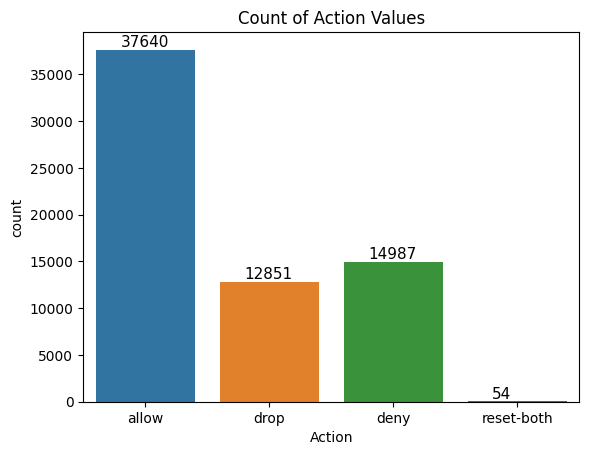

In [105]:
# มี imbalance data ใน action == reset-both
ax = sns.countplot(data=df, x="Action")
ax.set_title('Count of Action Values')

for i in ax.patches:
    ax.text(i.get_x()+0.2, i.get_height()+300, str(int(i.get_height())), fontsize=11, color='black')
plt.show()

In [106]:
count_action_allow = len(df[df["Action"]=="allow"])
count_action_drop = len(df[df["Action"]=="drop"])
count_action_deny = len(df[df["Action"]=="deny"])
count_action_reset = len(df[df["Action"]=="reset-both"])

count_action = count_action_allow + count_action_drop + count_action_deny + count_action_reset

percentage_of_action_allow = count_action_allow/count_action
percentage_of_action_drop = count_action_drop/count_action
percentage_of_action_deny = count_action_deny/count_action
percentage_of_action_reset = count_action_reset/count_action

print(f"percentage of allow action is {round(percentage_of_action_allow*100, 2)} %")
print(f"percentage of drop action is {round(percentage_of_action_drop*100, 2)} %")
print(f"percentage of deny action is {round(percentage_of_action_deny*100, 2)} %")
print(f"percentage of reset action is {round(percentage_of_action_reset*100, 2)} %")

percentage of allow action is 57.44 %
percentage of drop action is 19.61 %
percentage of deny action is 22.87 %
percentage of reset action is 0.08 %


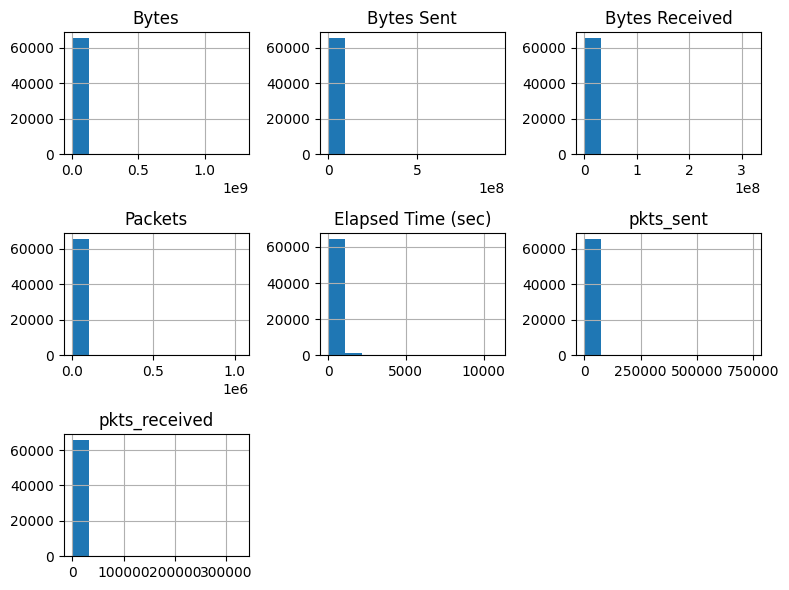

In [107]:
# create histogram of numerical feature
df.hist(figsize = (8, 6))
plt.tight_layout()
plt.show()

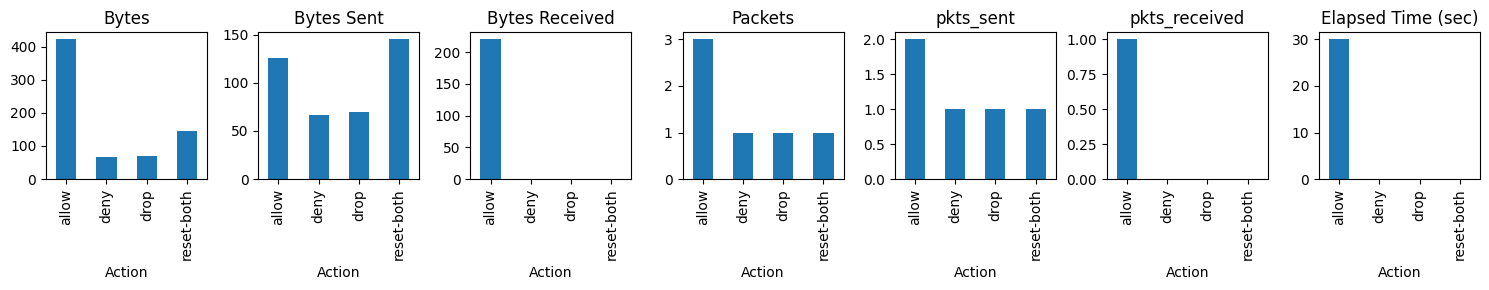

In [108]:
# ดูความต่างของ feature data แต่ละ action เห็นว่ามี pattern allow จะ byte, pkt, time เยอะกว่า action อื่น ส่วน action อื่นเท่ากันหมด
fig, axs = plt.subplots(ncols=7, figsize=(15, 3))

for i, col in enumerate(['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'pkts_sent', 'pkts_received', 'Elapsed Time (sec)']):
    action_median = df.groupby(['Action'])[col].median()
    action_median.plot(kind='bar', ax=axs[i])
    axs[i].set_title(col)

plt.tight_layout()
plt.show()

In [109]:
# # create histogram
# columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']

# fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(8, 6))
# axs = axs.flatten()

# # Create a histogram for each selected column on a separate subplot
# for i, col in enumerate(columns):
#     axs[i].hist(df[col], bins=20)
#     axs[i].set_title(col)

# plt.tight_layout()
# plt.show()

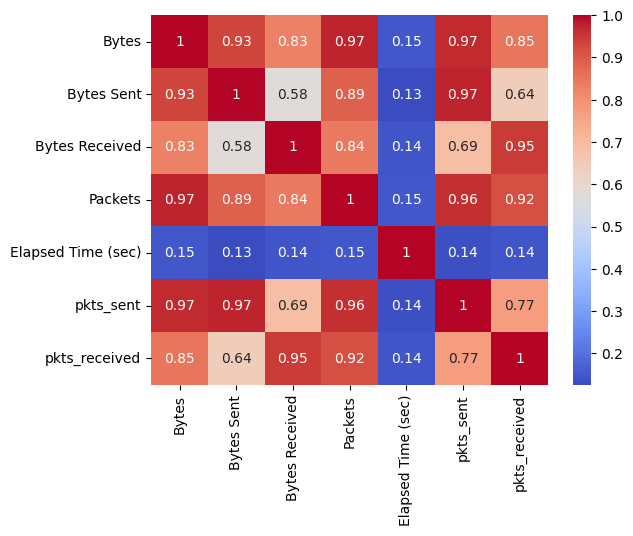

In [110]:
# Create a heatmap of the correlation coefficients
columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']
corr_matrix = df[columns].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

# packets และ bytes corr=~1 ตัด pkt ทิ้งได้

# Training Testing, Evaluation

In [111]:
X = df.drop(['Action', 'Packets', 'pkts_sent', 'pkts_received'], axis=1)
y = df['Action']

In [112]:
X_train, X_test, y_train, y_test=train_test_split(X,y,train_size=0.8, test_size=0.2, random_state=50)

In [113]:
print(f'target data before smote \n{y_train.value_counts()}\n')
sm = SMOTENC(random_state=42, categorical_features=[0, 1, 2, 3]) # define categorical features ['Source Port', 'Destination Port', 'NAT Source Port', 'NAT Destination Port']
X_train, y_train = sm.fit_resample(X_train, y_train)
print(f'target data after smote \n{y_train.value_counts()}')

target data before smote 
Action
allow         30107
deny          12036
drop          10241
reset-both       41
Name: count, dtype: int64

target data after smote 
Action
allow         30107
deny          30107
drop          30107
reset-both    30107
Name: count, dtype: int64


In [114]:
numericTransformer = Pipeline(steps=[('scaler', MinMaxScaler())])
catsTransformer = Pipeline(steps=[('OneHotEncoder', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(transformers=[('nums', numericTransformer, make_column_selector(dtype_include=int)),
                                               ('cats', catsTransformer, make_column_selector(dtype_include=object))])

In [115]:
tree = DecisionTreeClassifier()
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('tree', tree)])
treecv_scores = cross_val_score(tree_pipe, X, y, 
                                cv = 5,
                                scoring = 'f1_macro')

print("Mean cross-validation f1 macro score:", treecv_scores.mean())
print("Standard deviation:", treecv_scores.std())

Mean cross-validation f1 macro score: 0.9297572275309325
Standard deviation: 0.05308052016493374


In [116]:
knn = KNeighborsClassifier()
knn_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('knn', knn)])
knncv_scores = cross_val_score(knn_pipe, X, y,
                               cv = 5,
                               scoring = 'f1_macro')

print("Mean cross-validation f1 macro score:", knncv_scores.mean())
print("Standard deviation:", knncv_scores.std())

Mean cross-validation f1 macro score: 0.8535735927370041
Standard deviation: 0.12591440991529937


In [117]:
# Define the hyperparameter grid
param_grid = {
    'tree__max_depth': range(1, 11),
    'tree__criterion': ['entropy', 'gini']
}

# Use grid search to find the best hyperparameters
tree_grid = GridSearchCV(tree_pipe, param_grid, cv=5, scoring = 'f1_macro')
tree_grid.fit(X_train, y_train)

# Print the best hyperparameters and the score on the test set
print('Best hyperparameters:', tree_grid.best_params_)
print('Test set score:', tree_grid.score(X_test, y_test))

Best hyperparameters: {'tree__criterion': 'entropy', 'tree__max_depth': 10}
Test set score: 0.9653815056895183


In [118]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=10)
tree_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                           ('tree', tree)])

tree_pipe.fit(X_train, y_train)
pred = tree_pipe.predict(X_test)
print('confusion_matrix')
print(confusion_matrix(y_test, pred))
print('\nclassification_report')
print(classification_report(y_test, pred))
print(f"f1 score macro : {f1_score(y_test, pred, average='macro')}")

confusion_matrix
[[7524    9    0    0]
 [   0 2938   13    0]
 [   0    2 2608    0]
 [   0    3    0   10]]

classification_report
              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7533
        deny       1.00      1.00      1.00      2951
        drop       1.00      1.00      1.00      2610
  reset-both       1.00      0.77      0.87        13

    accuracy                           1.00     13107
   macro avg       1.00      0.94      0.97     13107
weighted avg       1.00      1.00      1.00     13107

f1 score macro : 0.9653815056895183


In [119]:
# knnpipe.fit(X_train, y_train)
# pred = knnpipe.predict(X_test)
# print('confusion_matrix')
# print(confusion_matrix(y_test, pred))
# print('\nclassification_report')
# print(classification_report(y_test, pred))

In [120]:
# from sklearn.svm import SVC

# svm = SVC()
# svmpipe = Pipeline(steps=[('preprocessor', preprocessor),
#                            ('svm', svm)])

# svmpipe.fit(X_train, y_train)
# pred = svmpipe.predict(X_test)
# # print(knnpipe.score(X_test, y_test))
# print(confusion_matrix(y_test, pred))
# print(classification_report(y_test, pred))

In [121]:
# svmncv_scores = cross_val_score(svmpipe, X, y, cv=5)

# print("Mean cross-validation score:", svmncv_scores.mean())
# print("Standard deviation:", svmncv_scores.std())